In [8]:
import numpy as np

In [2]:
import pandas as pd

In [3]:
df1 = pd.read_csv("train_cancer.csv")

In [4]:
df2 = pd.read_csv("test_cancer_pub.csv")

In [5]:
df1.head()

,1,1.1,2,1.2,3,1.3,1.4,1.5,0
0,4,1,1,1,2,2,1,1,0
1,3,1,1,1,2,3,1,1,0
2,5,5,5,6,3,3,1,1,1
3,3,1,1,1,2,3,1,1,0
4,1,1,1,1,2,3,1,1,0


In [6]:
df2.head()

,5,10,10.1,10.2,6,6.1,5.1,2
0,8,8,9,4,5,7,8,1
1,8,10,10,10,6,10,10,1
2,5,4,3,1,2,2,3,1
3,8,5,6,2,3,6,6,1
4,1,1,1,1,1,3,1,1


In [9]:
np.random.seed(42)
import matplotlib.pyplot as plt
import logging

In [10]:
logging.basicConfig(
    format='%(asctime)s %(levelname)-8s %(message)s',
    level=logging.INFO,
    datefmt='%Y-%m-%d %H:%M:%S')

In [11]:
# GLOBAL PARAMETERS FOR STOCHASTIC GRADIENT DESCENT
step_size=0.0001
max_iters=1000

In [12]:
def main():

  # Load the training data
  logging.info("Loading data")
  X_train, y_train, X_test = loadData()

  logging.info("\n---------------------------------------------------------------------------\n")

  # Fit a logistic regression model on train and plot its losses
  logging.info("Training logistic regression model (No Bias Term)")
  w, losses = trainLogistic(X_train,y_train)
  y_pred_train = X_train@w >= 0
  
  logging.info("Learned weight vector: {}".format([np.round(a,4)[0] for a in w]))
  logging.info("Train accuracy: {:.4}%".format(np.mean(y_pred_train == y_train)*100))
  
  logging.info("\n---------------------------------------------------------------------------\n")

  X_train_bias = dummyAugment(X_train)
 
  # Fit a logistic regression model on train and plot its losses
  logging.info("Training logistic regression model (Added Bias Term)")
  w, bias_losses = trainLogistic(X_train_bias,y_train)
  y_pred_train = X_train_bias@w >= 0
  
  logging.info("Learned weight vector: {}".format([np.round(a,4)[0] for a in w]))
  logging.info("Train accuracy: {:.4}%".format(np.mean(y_pred_train == y_train)*100))


  plt.figure(figsize=(16,9))
  plt.plot(range(len(losses)), losses, label="No Bias Term Added")
  plt.plot(range(len(bias_losses)), bias_losses, label="Bias Term Added")
  plt.title("Logistic Regression Training Curve")
  plt.xlabel("Epoch")
  plt.ylabel("Negative Log Likelihood")
  plt.legend()
  plt.show()

  logging.info("\n---------------------------------------------------------------------------\n")

  logging.info("Running cross-fold validation for bias case:")

  # Perform k-fold cross
  for k in [2,3,4, 5, 10, 20, 50]:
    cv_acc, cv_std = kFoldCrossVal(X_train_bias, y_train, k)
    logging.info("{}-fold Cross Val Accuracy -- Mean (stdev): {:.4}% ({:.4}%)".format(k,cv_acc*100, cv_std*100))

  ####################################################
  # Write the code to make your test submission here
  ####################################################
  

  raise Exception('Student error: You haven\'t implemented the code in main() to make test predictions.')

In [21]:
######################################################################
# Q3.1 logistic 
######################################################################
# Given an input vector z, return a vector of the outputs of a logistic
# function applied to each input value
#
# Input: 
#   z --   a n-by-1 vector
#
# Output:
#   logit_z --  a n-by-1 vector where logit_z[i] is the result of 
#               applying the logistic function to z[i]
######################################################################
def logistic(z):
  logit_z = 1 / (1 + np.exp(-z))
  return logit_z

In [23]:
z = np.array([19, 10, 0.5, 0.7, 0.6])

In [24]:
logistic(z)

array([0.99999999, 0.9999546 , 0.62245933, 0.66818777, 0.64565631])

## Calculate Negative Log Likelihood

In [51]:
######################################################################
# Q3.2 calculateNegativeLogLikelihood 
######################################################################
# Given an input data matrix X, label vector y, and weight vector w
# compute the negative log likelihood of a logistic regression model
# using w on the data defined by X and y
#
# Input: 
#   X --   a n-by-d matrix of examples where each row
#                   corresponds to a single d-dimensional example
#
#   y --    a n-by-1 vector representing the labels of the examples in X
#
#   w --    a d-by-1 weight bector
#
# Output:
#   nll --  the value of the negative log-likelihood
######################################################################
def calculateNegativeLogLikelihood(X,y,w):
  nll = 0
  n = X.shape[0]
  d = X.shape[1]
  
  for i in range(n):
    # part 1 of equation
    unit1 = np.transpose(w)
    unit2 = np.dot(unit1, X[i])
    unit3 = logistic(unit2)
    unit4 = np.log(unit3)
    part1 = np.dot(y[i], unit4)
    
    # part 2 of equation
    unit_a = np.log(1 - unit3)
    unit_b = 1 - y[i]
    part2 = np.dot(unit_a, unit_b)
    
    # combine the equation
    combined = part1 + part2
    nll = nll + combined
  
  # negative function
  nll = -nll
  return nll

In [60]:
######################################################################
# Q4 trainLogistic
######################################################################
# Given an input data matrix X, label vector y, maximum number of 
# iterations max_iters, and step size step_size -- run max_iters of 
# gradient descent with a step size of step_size to optimize a weight
# vector that minimizies negative log-likelihood on the data defined
# by X and y
#
# Input: 
#   X --   a n-by-d matrix of examples where each row
#                   corresponds to a single d-dimensional example
#
#   y --    a n-by-1 vector representing the labels of the examples in X
#
#   max_iters --   the maximum number of gradient descent iterations
#
#   step_size -- the step size (or learning rate) for gradient descent
#
# Output:
#   w --  the d-by-1 weight vector at the end of training
#
#   losses -- a list of negative log-likelihood values for each iteration
######################################################################
def trainLogistic(X,y, max_iters=max_iters, step_size=step_size):

    # Initialize our weights with zeros
    w = np.zeros( (X.shape[1],1) )
    w_grad = None
    
    # Keep track of losses for plotting
    losses = [calculateNegativeLogLikelihood(X,y,w)]
    
    # Take up to max_iters steps of gradient descent
    for i in range(max_iters):
        
        # Todo: Compute the gradient over the dataset and store in w_grad
        # .
        # . Implement equation 9.
        # .
        unit1 = np.dot(X, w)
        unit2 = logistic(unit1)
        unit3 = np.subtract(unit2, y)
        unit4 = np.transpose(X)
        unit5 = np.dot(unit4, unit3)
        w_grad = np.dot(unit4, unit5)

        # This is here to make sure your gradient is the right shape
        assert(w_grad.shape == (X.shape[1],1))

        # Take the update step in gradient descent
        w = w - step_size*w_grad
        
        # Calculate the negative log-likelihood with the 
        # new weight vector and store it for plotting later
        losses.append(calculateNegativeLogLikelihood(X,y,w))
        
    return w, losses

In [46]:
######################################################################
# Q5 dummyAugment
######################################################################
# Given an input data matrix X, add a column of ones to the left-hand
# side
#
# Input: 
#   X --   a n-by-d matrix of examples where each row
#                   corresponds to a single d-dimensional example
#
# Output:
#   aug_X --  a n-by-(d+1) matrix of examples where each row
#                   corresponds to a single d-dimensional example
#                   where the the first column is all ones
#
######################################################################
def dummyAugment(X):
    n = np.shape(X)
    first_column = np.ones(n)
    # splits an array into multiple sub-arrays horizontally (column-wise)
    aug_X = np.hstack((X, first_column))
    return aug_X

In [29]:
#Look at df1
df1

#dfX has first 10 rows of df1
dfX = df1.head(10)
dfX

#dfy has label from dfX 
dfY = dfX.iloc[:,8]
dfY

#drop label column from dfX
dfX = dfX.drop(dfX.columns[8], axis=1)
dfX

#get numpy array for X
X = np.array(dfX)
X

#get numpy array for y
y = np.array(dfY)
y

array([0, 0, 1, 0, 0, 0, 1, 1, 1, 0])

In [31]:
X

array([[ 4,  1,  1,  1,  2,  2,  1,  1],
       [ 3,  1,  1,  1,  2,  3,  1,  1],
       [ 5,  5,  5,  6,  3,  3,  1,  1],
       [ 3,  1,  1,  1,  2,  3,  1,  1],
       [ 1,  1,  1,  1,  2,  3,  1,  1],
       [ 3,  3,  2,  1,  3,  3,  6,  1],
       [ 5,  6,  6,  8,  6,  4, 10,  4],
       [ 8,  4, 10,  5,  4,  7, 10,  1],
       [ 5,  3,  3,  1,  3,  3,  3,  3],
       [ 2,  1,  1,  1,  2,  3,  1,  1]])

In [33]:
np.shape(X)

(10, 8)

In [35]:
np.shape(y)

(10,)

In [36]:
w = np.array([0.0, 0.001, 0.002, 0.0003, -0.001, -0.002, -0.003, 0.004 ])
w

array([ 0.    ,  0.001 ,  0.002 ,  0.0003, -0.001 , -0.002 , -0.003 ,
        0.004 ])

In [37]:
w.shape

(8,)

In [38]:
n = y.shape[0]

In [39]:
n

10

In [52]:
calculateNegativeLogLikelihood(X,y,w)

6.922470864619774

In [56]:
def calculateNegativeLogLikelihood(X,y,w):
  nll = 0
  rows = X.shape[0]
  
  for row in range(0, rows):
    # part 1 of equation
    unit1 = np.transpose(w)
    unit2 = np.matmul(unit1, X[row])
    unit3 = logistic(unit2)
    unit4 = np.log(unit3 + 0.00001)
    unit5 = y[row] * unit4
    
    # part 2 of equation
    unit6 = np.log(1 - unit3 + 0.00001)
    unit7 = 1 - y[row]
    unit8 = unit6 * unit7
    
    # combine the equation
    unit9 = unit5 + unit8
    nll = nll + unit9
  
  # change to negative
  nll = -nll
  return nll

In [57]:
calculateNegativeLogLikelihood(X,y,w)

6.922271044650455

In [98]:
def dummyAugment(X):
  n = X.shape[0]
  ones_column = np.ones((n, 1))
  # make the first column all ones with hstack
  aug_X = np.hstack((ones_column, X))
  return aug_X

In [90]:
X.shape[0]

10

In [97]:
np.ones((X.shape[0], 1))

array([[1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.]])

In [100]:
dummyAugment(X)

array([[ 1.,  4.,  1.,  1.,  1.,  2.,  2.,  1.,  1.],
       [ 1.,  3.,  1.,  1.,  1.,  2.,  3.,  1.,  1.],
       [ 1.,  5.,  5.,  5.,  6.,  3.,  3.,  1.,  1.],
       [ 1.,  3.,  1.,  1.,  1.,  2.,  3.,  1.,  1.],
       [ 1.,  1.,  1.,  1.,  1.,  2.,  3.,  1.,  1.],
       [ 1.,  3.,  3.,  2.,  1.,  3.,  3.,  6.,  1.],
       [ 1.,  5.,  6.,  6.,  8.,  6.,  4., 10.,  4.],
       [ 1.,  8.,  4., 10.,  5.,  4.,  7., 10.,  1.],
       [ 1.,  5.,  3.,  3.,  1.,  3.,  3.,  3.,  3.],
       [ 1.,  2.,  1.,  1.,  1.,  2.,  3.,  1.,  1.]])

In [101]:
np.subtract(logistic(np.dot(X, w)), y)

array([ 0.499575  ,  0.499075  , -0.49780001,  0.499075  ,  0.499075  ,
        0.49607508, -0.50189999, -0.50462487, -0.499175  ,  0.499075  ])

In [102]:
unit1 = np.subtract(logistic(np.dot(X, w)), y)

In [103]:
np.dot(unit1, X)

array([-3.55317372, -5.03232424, -8.55614853, -7.03234927, -1.54084921,
       -0.05462383, -6.58824812, -1.51559976])

In [105]:
np.transpose(X)

array([[ 4,  3,  5,  3,  1,  3,  5,  8,  5,  2],
       [ 1,  1,  5,  1,  1,  3,  6,  4,  3,  1],
       [ 1,  1,  5,  1,  1,  2,  6, 10,  3,  1],
       [ 1,  1,  6,  1,  1,  1,  8,  5,  1,  1],
       [ 2,  2,  3,  2,  2,  3,  6,  4,  3,  2],
       [ 2,  3,  3,  3,  3,  3,  4,  7,  3,  3],
       [ 1,  1,  1,  1,  1,  6, 10, 10,  3,  1],
       [ 1,  1,  1,  1,  1,  1,  4,  1,  3,  1]])

In [111]:
def trainLogistic(X,y, max_iters=max_iters, step_size=step_size):

    # Initialize our weights with zeros
    w = np.zeros( (X.shape[1],1) )
    w_grad = None
    
    # Keep track of losses for plotting
    losses = [calculateNegativeLogLikelihood(X,y,w)]
    
    # Take up to max_iters steps of gradient descent
    for i in range(max_iters):
        
        # Todo: Compute the gradient over the dataset and store in w_grad
        # .
        # . Implement equation 9.
        # .
        gradientW = np.zeros((X.shape[1], 1))

        for i, x in enumerate(X):
          gw = (logistic(w.T @ x) - y[i]) * x
          gradientW = gradientW + gw[:, np.axis]

        # This is here to make sure your gradient is the right shape
        assert(w_grad.shape == (X.shape[1],1))

        # Take the update step in gradient descent
        w = w - step_size*w_grad
        
        # Calculate the negative log-likelihood with the
        # new weight vector and store it for plotting later
        losses.append(calculateNegativeLogLikelihood(X,y,w))
        
    return w, losses

In [110]:
trainLogistic(X, y, m, s)

NameError: name 'm' is not defined

2022-10-26 22:38:14 INFO     Loading data
2022-10-26 22:38:14 INFO     
---------------------------------------------------------------------------

2022-10-26 22:38:14 INFO     Training logistic regression model (No Bias Term)
/var/folders/j7/v7fxqplj159bfs5m8bw5sdn00000gn/T/ipykernel_68073/2757863872.py:96: RuntimeWarning: overflow encountered in exp
  logit_z = (1 / (1+np.exp(-z)))
2022-10-26 22:38:23 INFO     Learned weight vector: [-87.7919, 167.6616, 47.5216, 58.2126, -149.0181, -83.6144, 82.7278, -70.4516]
2022-10-26 22:38:23 INFO     Train accuracy: 80.9%
2022-10-26 22:38:23 INFO     
---------------------------------------------------------------------------

2022-10-26 22:38:23 INFO     Training logistic regression model (Added Bias Term)
2022-10-26 22:38:31 INFO     Learned weight vector: [-397.5948, 27.1842, -5.0651, 22.6377, 24.2847, 7.1467, 16.5566, 13.3753, 32.7151]
2022-10-26 22:38:31 INFO     Train accuracy: 97.42%


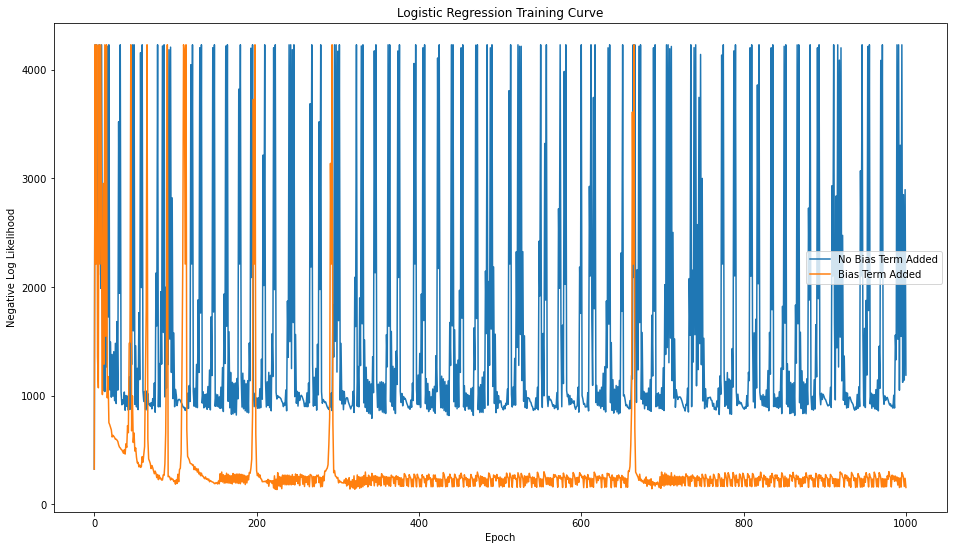

2022-10-26 22:38:31 INFO     
---------------------------------------------------------------------------

2022-10-26 22:38:31 INFO     Running cross-fold validation for bias case:


In [137]:
import numpy as np
np.random.seed(42)
import matplotlib.pyplot as plt
import logging
logging.basicConfig(
    format='%(asctime)s %(levelname)-8s %(message)s',
    level=logging.INFO,
    datefmt='%Y-%m-%d %H:%M:%S')

# GLOBAL PARAMETERS FOR STOCHASTIC GRADIENT DESCENT
step_size=0.1
max_iters=1000
epsilon = 0.000001

def main():

  # Load the training data
  logging.info("Loading data")
  X_train, y_train, X_test = loadData()

  logging.info("\n---------------------------------------------------------------------------\n")

  # Fit a logistic regression model on train and plot its losses
  logging.info("Training logistic regression model (No Bias Term)")
  w, losses = trainLogistic(X_train,y_train)
  y_pred_train = X_train@w >= 0
  
  logging.info("Learned weight vector: {}".format([np.round(a,4)[0] for a in w]))
  logging.info("Train accuracy: {:.4}%".format(np.mean(y_pred_train == y_train)*100))
  
  logging.info("\n---------------------------------------------------------------------------\n")

  X_train_bias = dummyAugment(X_train)
 
  # Fit a logistic regression model on train and plot its losses
  logging.info("Training logistic regression model (Added Bias Term)")
  w, bias_losses = trainLogistic(X_train_bias,y_train)
  y_pred_train = X_train_bias@w >= 0
  
  logging.info("Learned weight vector: {}".format([np.round(a,4)[0] for a in w]))
  logging.info("Train accuracy: {:.4}%".format(np.mean(y_pred_train == y_train)*100))


  plt.figure(figsize=(16,9))
  plt.plot(range(len(losses)), losses, label="No Bias Term Added")
  plt.plot(range(len(bias_losses)), bias_losses, label="Bias Term Added")
  plt.title("Logistic Regression Training Curve")
  plt.xlabel("Epoch")
  plt.ylabel("Negative Log Likelihood")
  plt.legend()
  plt.show()

  logging.info("\n---------------------------------------------------------------------------\n")

  logging.info("Running cross-fold validation for bias case:")

  # Perform k-fold cross
  # for k in [2,3,4, 5, 10, 20, 50]:
  #   cv_acc, cv_std = kFoldCrossVal(X_train_bias, y_train, k)
  #   logging.info("{}-fold Cross Val Accuracy -- Mean (stdev): {:.4}% ({:.4}%)".format(k,cv_acc*100, cv_std*100))

  ####################################################
  # Write the code to make your test submission here
  ####################################################

  # Use bias
  # TODO set your best k value and then run on the test set
  # Make predictions on test set
  X_test_bias = dummyAugment(X_test)
  # matrix multiplication
  pred_test_y = X_test_bias@w>=0

  # add index and header then save to file
  test_out = np.concatenate((np.expand_dims(np.array(range(pred_test_y.size),dtype=np.int32), axis=1), pred_test_y), axis=1)
  header = np.array([["id", "type"]])
  test_out = np.concatenate((header, test_out))
  np.savetxt('test_predicted1.csv', test_out, fmt='%s', delimiter=',')

  


######################################################################
# Q3.1 logistic 
######################################################################
# Given an input vector z, return a vector of the outputs of a logistic
# function applied to each input value
#
# Input: 
#   z --   a n-by-1 vector
#
# Output:
#   logit_z --  a n-by-1 vector where logit_z[i] is the result of 
#               applying the logistic function to z[i]
######################################################################
def logistic(z):
  logit_z = (1 / (1+np.exp(-z)))
  return logit_z


######################################################################
# Q3.2 calculateNegativeLogLikelihood 
######################################################################
# Given an input data matrix X, label vector y, and weight vector w
# compute the negative log likelihood of a logistic regression model
# using w on the data defined by X and y
#
# Input: 
#   X --   a n-by-d matrix of examples where each row
#                   corresponds to a single d-dimensional example
#
#   y --    a n-by-1 vector representing the labels of the examples in X
#
#   w --    a d-by-1 weight bector
#
# Output:
#   nll --  the value of the negative log-likelihood
######################################################################
def calculateNegativeLogLikelihood(X,y,w):
  nll = 0
  rows = X.shape[0]
  
  for row in range(0, rows):
    # part 1 of equation
    unit1 = np.transpose(w)
    unit2 = np.matmul(unit1, X[row])
    unit3 = logistic(unit2)
    unit4 = np.log(unit3 + epsilon)
    unit5 = y[row] * unit4
    
    # part 2 of equation
    unit6 = np.log(1 - unit3 + epsilon)
    unit7 = 1 - y[row]
    unit8 = unit6 * unit7
    
    # combine the equation
    unit9 = unit5 + unit8
    nll = nll + unit9
  
  # change to negative
  nll = -nll
  return nll

######################################################################
# Q4 trainLogistic
######################################################################
# Given an input data matrix X, label vector y, maximum number of 
# iterations max_iters, and step size step_size -- run max_iters of 
# gradient descent with a step size of step_size to optimize a weight
# vector that minimizies negative log-likelihood on the data defined
# by X and y
#
# Input: 
#   X --   a n-by-d matrix of examples where each row
#                   corresponds to a single d-dimensional example
#
#   y --    a n-by-1 vector representing the labels of the examples in X
#
#   max_iters --   the maximum number of gradient descent iterations
#
#   step_size -- the step size (or learning rate) for gradient descent
#
# Output:
#   w --  the d-by-1 weight vector at the end of training
#
#   losses -- a list of negative log-likelihood values for each iteration
######################################################################
def trainLogistic(X,y, max_iters=max_iters, step_size=step_size):
    # Initialize our weights with zeros
    w = np.zeros((X.shape[1],1))
    # Keep track of losses for plotting
    losses = [calculateNegativeLogLikelihood(X,y,w)]
    
    # Take up to max_iters steps of gradient descent
    for i in range(max_iters):
        # Todo: Compute the gradient over the dataset and store in w_grad
        # .
        # .  Implement equation 9.
        # .
        gradientW = np.zeros((X.shape[1],1))
        
        for i, x in enumerate(X):
            gw = (logistic(w.T @ x) - y[i]) * x
            gradientW = gradientW + gw[:, np.newaxis]

        # This is here to make sure your gradient is the right shape
        assert(gradientW.shape == (X.shape[1],1))

        # Take the update step in gradient descent
        w = w - step_size * gradientW
        
        # Calculate the negative log-likelihood with the
        # new weight vector and store it for plotting later
        losses.append(calculateNegativeLogLikelihood(X,y,w))
    
        
    return w, losses


######################################################################
# Q5 dummyAugment
######################################################################
# Given an input data matrix X, add a column of ones to the left-hand
# side
#
# Input: 
#   X --   a n-by-d matrix of examples where each row
#                   corresponds to a single d-dimensional example
#
# Output:
#   aug_X --  a n-by-(d+1) matrix of examples where each row
#                   corresponds to a single d-dimensional example
#                   where the the first column is all ones
#
######################################################################
def dummyAugment(X):
  n = X.shape[0]
  ones_column = np.ones((n, 1))
  # make the first column all ones with hstack
  aug_X = np.hstack((ones_column, X))
  return aug_X


##################################################################
# Instructor Provided Code, Don't need to modify but should read
##################################################################

# Given a matrix X (n x d) and y (n x 1), perform k fold cross val.
def kFoldCrossVal(X, y, k):
  fold_size = int(np.ceil(len(X)/k))
  
  rand_inds = np.random.permutation(len(X))
  X = X[rand_inds]
  y = y[rand_inds]

  acc = []
  inds = np.arange(len(X))
  for j in range(k):
    
    start = min(len(X),fold_size*j)
    end = min(len(X),fold_size*(j+1))
    test_idx = np.arange(start, end)
    train_idx = np.concatenate( [np.arange(0,start), np.arange(end, len(X))] )
    if len(test_idx) < 2:
      break

    X_fold_test = X[test_idx]
    y_fold_test = y[test_idx]
    
    X_fold_train = X[train_idx]
    y_fold_train = y[train_idx]

    w, losses = trainLogistic(X_fold_train, y_fold_train)

    acc.append(np.mean((X_fold_test@w >= 0) == y_fold_test))

  return np.mean(acc), np.std(acc)


# Loads the train and test splits, passes back x/y for train and just x for test
def loadData():
  train = np.loadtxt("train_cancer.csv", delimiter=",")
  test = np.loadtxt("test_cancer_pub.csv", delimiter=",")
  
  X_train = train[:, 0:-1]
  y_train = train[:, -1]
  X_test = test
  
  return X_train, y_train[:, np.newaxis], X_test   # The np.newaxis trick changes it from a (n,) matrix to a (n,1) matrix.


main()


2022-10-26 22:30:27 INFO     Loading data
2022-10-26 22:30:27 INFO     
---------------------------------------------------------------------------

2022-10-26 22:30:27 INFO     Training logistic regression model (No Bias Term)
/var/folders/j7/v7fxqplj159bfs5m8bw5sdn00000gn/T/ipykernel_68073/819701971.py:96: RuntimeWarning: overflow encountered in exp
  logit_z = (1 / (1 + np.exp(-z)))
2022-10-26 22:30:33 INFO     Learned weight vector: [-87.7919, 167.6616, 47.5216, 58.2126, -149.0181, -83.6144, 82.7278, -70.4516]
2022-10-26 22:30:33 INFO     Train accuracy: 80.9%
2022-10-26 22:30:33 INFO     
---------------------------------------------------------------------------

2022-10-26 22:30:33 INFO     Training logistic regression model (Added Bias Term)
2022-10-26 22:30:38 INFO     Learned weight vector: [-422.762, 30.4434, -4.4461, 23.538, 27.3277, 6.8134, 18.886, 15.5549, 35.0088]
2022-10-26 22:30:38 INFO     Train accuracy: 97.21%


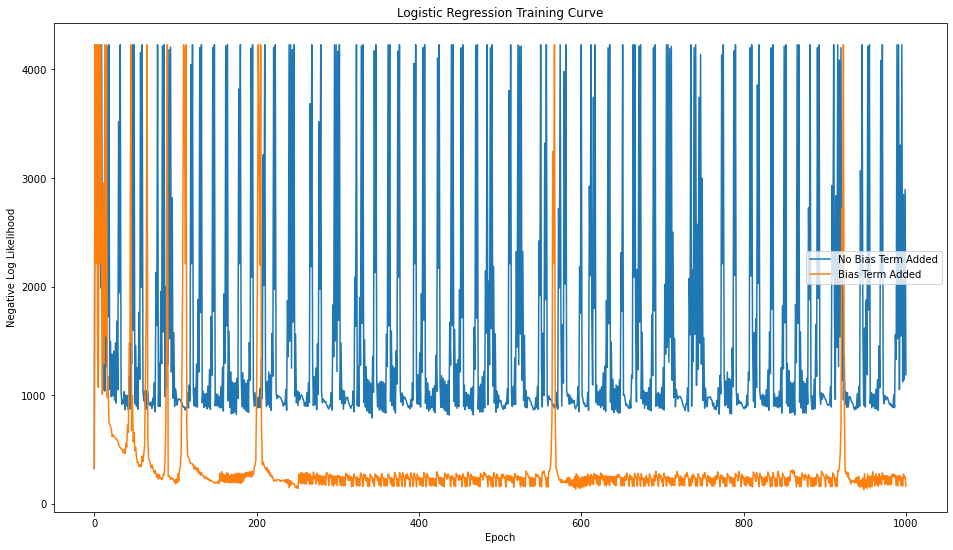

2022-10-26 22:30:38 INFO     
---------------------------------------------------------------------------

2022-10-26 22:30:38 INFO     Running cross-fold validation for bias case:
2022-10-26 22:30:44 INFO     2-fold Cross Val Accuracy -- Mean (stdev): 95.06% (1.931%)
2022-10-26 22:30:55 INFO     3-fold Cross Val Accuracy -- Mean (stdev): 96.78% (0.5238%)
2022-10-26 22:31:11 INFO     4-fold Cross Val Accuracy -- Mean (stdev): 96.14% (0.7515%)
2022-10-26 22:31:33 INFO     5-fold Cross Val Accuracy -- Mean (stdev): 96.12% (2.224%)
2022-10-26 22:32:22 INFO     10-fold Cross Val Accuracy -- Mean (stdev): 95.43% (4.136%)
2022-10-26 22:34:05 INFO     20-fold Cross Val Accuracy -- Mean (stdev): 96.25% (3.2%)
2022-10-26 22:38:14 INFO     50-fold Cross Val Accuracy -- Mean (stdev): 95.11% (6.144%)
/var/folders/j7/v7fxqplj159bfs5m8bw5sdn00000gn/T/ipykernel_68073/819701971.py:74: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself

In [136]:
import numpy as np
np.random.seed(42)
import matplotlib.pyplot as plt
import logging
logging.basicConfig(
    format='%(asctime)s %(levelname)-8s %(message)s',
    level=logging.INFO,
    datefmt='%Y-%m-%d %H:%M:%S')

# GLOBAL PARAMETERS FOR STOCHASTIC GRADIENT DESCENT
step_size=0.00001
max_iters=1000
epsilon = 0.000001

def main():

  # Load the training data
  logging.info("Loading data")
  X_train, y_train, X_test = loadData()

  logging.info("\n---------------------------------------------------------------------------\n")

  # Fit a logistic regression model on train and plot its losses
  logging.info("Training logistic regression model (No Bias Term)")
  w, losses = trainLogistic(X_train,y_train)
  y_pred_train = X_train@w >= 0
  
  logging.info("Learned weight vector: {}".format([np.round(a,4)[0] for a in w]))
  logging.info("Train accuracy: {:.4}%".format(np.mean(y_pred_train == y_train)*100))
  
  logging.info("\n---------------------------------------------------------------------------\n")

  X_train_bias = dummyAugment(X_train)
 
  # Fit a logistic regression model on train and plot its losses
  logging.info("Training logistic regression model (Added Bias Term)")
  w, bias_losses = trainLogistic(X_train_bias,y_train)
  y_pred_train = X_train_bias@w >= 0
  
  logging.info("Learned weight vector: {}".format([np.round(a,4)[0] for a in w]))
  logging.info("Train accuracy: {:.4}%".format(np.mean(y_pred_train == y_train)*100))


  plt.figure(figsize=(16,9))
  plt.plot(range(len(losses)), losses, label="No Bias Term Added")
  plt.plot(range(len(bias_losses)), bias_losses, label="Bias Term Added")
  plt.title("Logistic Regression Training Curve")
  plt.xlabel("Epoch")
  plt.ylabel("Negative Log Likelihood")
  plt.legend()
  plt.show()

  logging.info("\n---------------------------------------------------------------------------\n")

  logging.info("Running cross-fold validation for bias case:")

  # Perform k-fold cross
  for k in [2,3,4, 5, 10, 20, 50]:
    cv_acc, cv_std = kFoldCrossVal(X_train_bias, y_train, k)
    logging.info("{}-fold Cross Val Accuracy -- Mean (stdev): {:.4}% ({:.4}%)".format(k,cv_acc*100, cv_std*100))

  ####################################################
  # Write the code to make your test submission here
  ####################################################

  # Use bias
  # TODO set your best k value and then run on the test set
  # Make predictions on test set
  X_test_bias = dummyAugment(X_test)
  # matrix multiplication
  pred_test_y = X_test_bias@w>=0

  # add index and header then save to file
  test_out = np.concatenate((np.expand_dims(np.array(range(pred_test_y.size),dtype=np.int), axis=1), pred_test_y), axis=1)
  header = np.array([["id", "type"]])
  test_out = np.concatenate((header, test_out))
  np.savetxt('test_predicted.csv', test_out, fmt='%s', delimiter=',')

  


######################################################################
# Q3.1 logistic 
######################################################################
# Given an input vector z, return a vector of the outputs of a logistic
# function applied to each input value
#
# Input: 
#   z --   a n-by-1 vector
#
# Output:
#   logit_z --  a n-by-1 vector where logit_z[i] is the result of 
#               applying the logistic function to z[i]
######################################################################
def logistic(z):
  logit_z = (1 / (1 + np.exp(-z)))
  return logit_z


######################################################################
# Q3.2 calculateNegativeLogLikelihood 
######################################################################
# Given an input data matrix X, label vector y, and weight vector w
# compute the negative log likelihood of a logistic regression model
# using w on the data defined by X and y
#
# Input: 
#   X --   a n-by-d matrix of examples where each row
#                   corresponds to a single d-dimensional example
#
#   y --    a n-by-1 vector representing the labels of the examples in X
#
#   w --    a d-by-1 weight bector
#
# Output:
#   nll --  the value of the negative log-likelihood
######################################################################
def calculateNegativeLogLikelihood(X,y,w):
  nll = 0
  rows = X.shape[0]
  
  for row in range(0, rows):
    # part 1 of equation
    unit1 = np.transpose(w)
    unit2 = np.matmul(unit1, X[row])
    unit3 = logistic(unit2)
    unit4 = np.log(unit3 + epsilon)
    unit5 = y[row] * unit4
    
    # part 2 of equation
    unit6 = np.log(1 - unit3 + epsilon)
    unit7 = 1 - y[row]
    unit8 = unit6 * unit7
    
    # combine the equation
    unit9 = unit5 + unit8
    nll = nll + unit9
  
  # change to negative
  nll = -nll
  return nll

######################################################################
# Q4 trainLogistic
######################################################################
# Given an input data matrix X, label vector y, maximum number of 
# iterations max_iters, and step size step_size -- run max_iters of 
# gradient descent with a step size of step_size to optimize a weight
# vector that minimizies negative log-likelihood on the data defined
# by X and y
#
# Input: 
#   X --   a n-by-d matrix of examples where each row
#                   corresponds to a single d-dimensional example
#
#   y --    a n-by-1 vector representing the labels of the examples in X
#
#   max_iters --   the maximum number of gradient descent iterations
#
#   step_size -- the step size (or learning rate) for gradient descent
#
# Output:
#   w --  the d-by-1 weight vector at the end of training
#
#   losses -- a list of negative log-likelihood values for each iteration
######################################################################
def trainLogistic(X,y, max_iters=max_iters, step_size=step_size):
    # Initialize our weights with zeros
    w = np.zeros((X.shape[1],1))
    # Keep track of losses for plotting
    losses = [calculateNegativeLogLikelihood(X,y,w)]
    
    # Take up to max_iters steps of gradient descent
    for i in range(max_iters):
        # Todo: Compute the gradient over the dataset and store in w_grad
        # .
        # .  Implement equation 9.
        # .
        gradient_w = X.T @ (logistic(X @ w)-y)

        # This is here to make sure your gradient is the right shape
        assert(gradient_w.shape == (X.shape[1],1))

        # Take the update step in gradient descent
        w = w - step_size * gradient_w
        
        # Calculate the negative log-likelihood with the
        # new weight vector and store it for plotting later
        losses.append(calculateNegativeLogLikelihood(X,y,w))
    
        
    return w, losses


######################################################################
# Q5 dummyAugment
######################################################################
# Given an input data matrix X, add a column of ones to the left-hand
# side
#
# Input: 
#   X --   a n-by-d matrix of examples where each row
#                   corresponds to a single d-dimensional example
#
# Output:
#   aug_X --  a n-by-(d+1) matrix of examples where each row
#                   corresponds to a single d-dimensional example
#                   where the the first column is all ones
#
######################################################################
def dummyAugment(X):
  n = X.shape[0]
  ones_column = np.ones((n, 1))
  # make the first column all ones with hstack
  aug_X = np.hstack((ones_column, X))
  return aug_X


##################################################################
# Instructor Provided Code, Don't need to modify but should read
##################################################################

# Given a matrix X (n x d) and y (n x 1), perform k fold cross val.
def kFoldCrossVal(X, y, k):
  fold_size = int(np.ceil(len(X)/k))
  
  rand_inds = np.random.permutation(len(X))
  X = X[rand_inds]
  y = y[rand_inds]

  acc = []
  inds = np.arange(len(X))
  for j in range(k):
    
    start = min(len(X),fold_size*j)
    end = min(len(X),fold_size*(j+1))
    test_idx = np.arange(start, end)
    train_idx = np.concatenate( [np.arange(0,start), np.arange(end, len(X))] )
    if len(test_idx) < 2:
      break

    X_fold_test = X[test_idx]
    y_fold_test = y[test_idx]
    
    X_fold_train = X[train_idx]
    y_fold_train = y[train_idx]

    w, losses = trainLogistic(X_fold_train, y_fold_train)

    acc.append(np.mean((X_fold_test@w >= 0) == y_fold_test))

  return np.mean(acc), np.std(acc)


# Loads the train and test splits, passes back x/y for train and just x for test
def loadData():
  train = np.loadtxt("train_cancer.csv", delimiter=",")
  test = np.loadtxt("test_cancer_pub.csv", delimiter=",")
  
  X_train = train[:, 0:-1]
  y_train = train[:, -1]
  X_test = test
  
  return X_train, y_train[:, np.newaxis], X_test   # The np.newaxis trick changes it from a (n,) matrix to a (n,1) matrix.


main()